<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Toy_Flow_cubic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrainement d'un bijector 1D avc TensorFlow (standard) 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

In [2]:
class Cubic(tfb.Bijector):
    def __init__(self, p, validate_args=False, name='Cubic'):

# Ok with _forward/_inverse/_forward_log_det_jacobian written with p[0],p[1]
        self.p = p 
        self.a = tf.cast(self.p[0], tf.float32)
        self.b = tf.cast(self.p[1], tf.float32)

# a,b as tf.Variable OK
#        self.a = tf.Variable(0.25, name='a')
#        self.b = tf.Variable(-0.1, name='b')

# a & b as argument and init as tf.Variable each Ok
#        self.a = tf.cast(a, tf.float32)
#        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self,x):
        x = tf.cast(x,tf.float32)
        #return tf.squeeze(tf.pow(self.a*x + self.b,3))
        return tf.squeeze(tf.pow(self.p[0]*x + self.p[1],3))

    def _inverse(self,y):
        y = tf.cast(y,tf.float32)
#        return (tf.math.sign(y)*tf.pow(tf.abs(y),1/3)-self.b)/self.a
        return (tf.math.sign(y)*tf.pow(tf.abs(y),1/3)-self.p[1])/self.p[0]
    
    def _forward_log_det_jacobian(self,x):
        x = tf.cast(x,tf.float32)
#        return tf.math.log(3.*tf.abs(self.a))+2.*tf.math.log(tf.abs(self.a*x+self.b))
        return tf.math.log(3.*tf.abs(self.p[0]))+2.*tf.math.log(tf.abs(self.p[0]*x+self.p[1]))

## A target distribution

In [43]:
use_case = 0  # 0 is perfect while 1 is not

normal = tfd.Normal(loc=0.,scale=1.)

if use_case == 0:
  truef = Cubic(tf.Variable([1.,1e-5]), validate_args=True)
  true_dist = tfd.TransformedDistribution(normal,tfb.Invert(truef))
else:
  # Alternative: use a asymetric  mixture of gaussian
  probs = [0.6,0.4]

  true_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=probs),
        components_distribution=tfd.Normal(
          loc=[2.3, -0.8],       # One for each component.
          scale=[0.4, 0.4]))  # And same here.



## Training/validation samples

In [44]:
x_train = true_dist.sample(seed=(1,23),sample_shape=(10_000,), name='train_spl')
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = true_dist.sample(seed=(1,24),sample_shape=(1000,), name='valid_spl')
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

In [45]:
transf = Cubic(tf.Variable([0.3,-0.1]))
trainable_inv_cubic = tfb.Invert(transf,validate_args=True)

In [46]:
#check if trainable_variables is non empty
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.3, -0.1], dtype=float32)>,)

In [47]:
trainable_dist = tfd.TransformedDistribution(normal,trainable_inv_cubic)

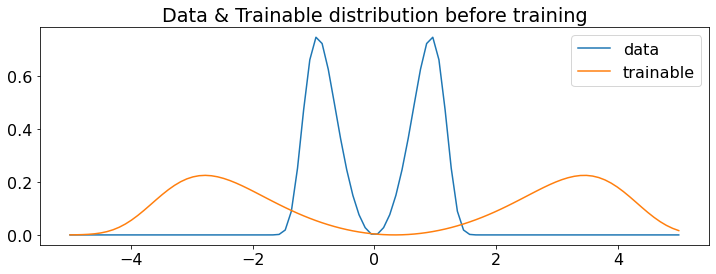

In [48]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x,true_dist.prob(x),label='data')
plt.plot(x,trainable_dist.prob(x),label='trainable')
plt.title('Data & Trainable distribution before training')
plt.legend()
plt.show()


In [49]:
num_epochs = 10
opt = tf.keras.optimizers.Adam(learning_rate=5e-3)
train_losses = []
valid_losses = []

all_p=[tf.convert_to_tensor(trainable_inv_cubic.trainable_variables[0]).numpy()]

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    
    # Train
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
    all_p.append(tf.convert_to_tensor(trainable_inv_cubic.trainable_variables[0]).numpy())

    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())


Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


## Check if the validation loss decreases

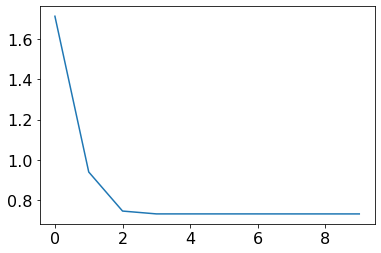

In [50]:
plt.plot(valid_losses)

## Have a look at intermediate trained distribution 

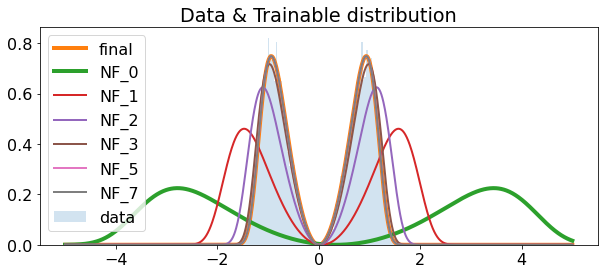

In [51]:
x = np.linspace(-5,5,1000)
plt.figure(figsize=(10,4))
#plt.plot(x,true_dist.prob(x),label='data')
plt.hist(true_dist.sample(seed=(1,23),sample_shape=(10_000)),density=True,bins=100,alpha=0.2, label="data");
plt.plot(x,trainable_dist.prob(x),label='final',lw=4)
for i in [0,1,2,3,5,7]:
  if i==0:
    lw=4
  else:
    lw=2  
  inverse_transf = tfb.Invert(Cubic(tf.Variable(all_p[i], name='p')))
  trans_dist = tfd.TransformedDistribution(normal,inverse_transf)
  plt.plot(x,trans_dist.prob(x),lw=lw,label="NF_"+str(i))
plt.title('Data & Trainable distribution')
plt.legend()
plt.show()

## Check if the fitted distribution leads to Gaussian original samples

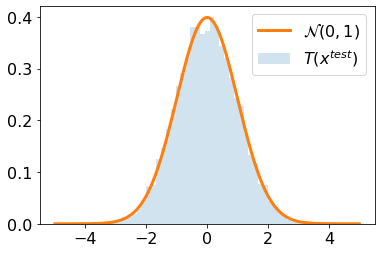

In [52]:
plt.hist(inverse_transf.inverse(true_dist.sample(seed=(1,23),sample_shape=(10_000,), name='train_spl')).numpy(), 
         bins=50,density=True,label="$T(x^{test})$",alpha=0.2);
plt.plot(x,normal.prob(x),label="$\mathcal{N}(0,1)$",lw=3)
plt.legend();

# Essai de MADE

In [58]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.enable_v2_behavior()

In [145]:
n = 10_000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)


In [91]:
type(data)

numpy.ndarray

In [92]:
joint = tfd.JointDistributionSequential([
  tfd.Normal(loc=0,scale=2), # x2
  lambda x2: tfd.Normal(loc=x2*x2/4.,scale=1)],
  batch_ndims=0, use_vectorized_map=True)


In [94]:
n = 2_000
x2b,x1b = joint.sample(sample_shape=(n))

In [131]:
data_bis = np.stack([x2b, x1b], axis=-1)

In [143]:
x = np.linspace(-3,6)
y = np.linspace(-6,6)
xv, yv = np.meshgrid(x, y, sparse=True)
z = joint.prob(x2=yv,x=xv)

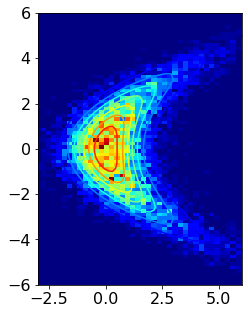

In [172]:
fig = plt.figure(figsize=(5,5))
plt.scatter(x1,x2,s=0.1)
plt.hist2d(x1,x2,density=True,bins=[100,100])
plt.contour(x,y,z)
plt.gca().set_aspect('equal')
plt.xlim([x.min(),x.max()])
plt.ylim([y.min(),y.max()])
plt.draw()

In [113]:
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10], activation='leaky_relu')

In [137]:
# A base distribtion as 2D Normal
base_dist=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2])
# generate 10 samples 2D
base_spl = base_dist.sample(sample_shape=(10_000))

In [155]:
base_spl.shape

TensorShape([10000, 2])

In [115]:
# The base distribution transformed by a MADE bijector
trans_dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=tfb.MaskedAutoregressiveFlow(made))


In [146]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = trans_dist.log_prob(x_)
model = tfk.Model(x_, log_prob_)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                loss=lambda _, log_prob: -log_prob) # signature of loss fn(y_true,output_of_the_model)

batch_size = 25
model.fit(x=data,
            y=np.zeros((n, 0), dtype=np.float32),
            batch_size=batch_size,
            epochs=50,
            steps_per_epoch=1,  # Usually `n // batch_size`.
            shuffle=True,
            verbose=True)

Epoch 1/50
1/1 [==============================] - 1s 653ms/step - loss: 4.6523
Epoch 2/50
1/1 [==============================] - 0s 14ms/step - loss: 5.1786
Epoch 3/50
1/1 [==============================] - 0s 10ms/step - loss: 4.0136
Epoch 4/50
1/1 [==============================] - 0s 9ms/step - loss: 4.4618
Epoch 5/50
1/1 [==============================] - 0s 10ms/step - loss: 3.9729
Epoch 6/50
1/1 [==============================] - 0s 9ms/step - loss: 3.8399
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 3.8132
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 3.9664
Epoch 9/50
1/1 [==============================] - 0s 13ms/step - loss: 3.8908
Epoch 10/50
1/1 [==============================] - 0s 11ms/step - loss: 4.0108
Epoch 11/50
1/1 [==============================] - 0s 16ms/step - loss: 3.9453
Epoch 12/50
1/1 [==============================] - 0s 11ms/step - loss: 4.3217
Epoch 13/50
1/1 [==============================] - 0s 9ms/step

In [168]:
spl= trans_dist.sample(100_000)

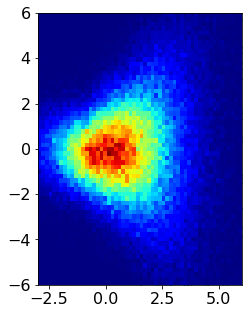

In [170]:
fig = plt.figure(figsize=(5,5))
#plt.scatter(spl[:,0],spl[:,1],s=0.1)
plt.hist2d(spl[:,0],spl[:,1],density=True,bins=[100,200])
#plt.scatter(base_spl[:,0],base_spl[:,1],s=0.1,c="k")
#plt.contour(x,y,z)
plt.gca().set_aspect('equal')

plt.xlim([x.min(),x.max()])
plt.ylim([y.min(),y.max()])
plt.draw()